# Exploratory Data Analysis

In [151]:
import pandas as pd
import numpy as np
from datetime import datetime



In [152]:
df = pd.read_csv("movie_statistic_dataset.csv")
df.columns = df.columns.str.lower().str.replace('$', '').str.replace(' ', '_')

<ipython-input-152-28621a4cda64>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.lower().str.replace('$', '').str.replace(' ', '_')


In [153]:
# Custom function to split the string and fill in "No Genre" if elements are missing;
# "No Genre" is better than NA in this scenario because we are going to encode the column later on
def split_genres(s):
    genres = s.split(",")
    if len(genres) >= 3:
        return genres[0], genres[1], genres[2]
    elif len(genres) == 2:
        return genres[0], genres[1], "No Genre"
    elif len(genres) == 1:
        return genres[0], "No Genre","No Genre"
    else:
        return "No Genre","No Genre","No Genre"

# Apply the custom function to create new columns
df['genre1'], df['genre2'], df['genre3'] = zip(*df['genres'].apply(split_genres))

#custom function to split director_professions
def split_jobs(s):
    jobs = s.split(",")
    if len(jobs) >= 3:
        return jobs[0], jobs[1], jobs[2]
    elif len(jobs) == 2:
        return jobs[0], jobs[1], "No director"
    elif len(jobs) == 1:
        return jobs[0], "No director","No director"
    else:
        return "No director","No director","No director"

# Apply the custom function to create new columns
#df['job1'], df['job2'], df['job3'] = zip(*df['director_professions'].apply(split_jobs))

#adding custom dummies
df['director'] = df["director_professions"].apply(lambda x: 1 if "director" in x.split(",") else 0)
df['writer'] = df["director_professions"].apply(lambda x: 1 if "writer" in x.split(",") else 0)
df['producer'] = df["director_professions"].apply(lambda x: 1 if "producer" in x.split(",") else 0)
df['actor'] = df["director_professions"].apply(lambda x: 1 if "actor" in x.split(",") else 0)




In [154]:
#handling these NAs in a specific manner because the columns are being encoded
df['genre1'].replace("\\N","No Genre",inplace = True)
#df['job1'].replace(np.nan,"No director",inplace = True)
#replace "-" and "\N" with null
df.replace("-",np.nan,inplace = True)
df.replace("\\N",np.nan,inplace = True)
#changing missing years to zeroes; open to different ideas
df['director_birthyear'].replace(np.nan,0,inplace=True)
df['director_deathyear'].replace(np.nan,0,inplace=True)
df['director_deathyear'].replace("alive",0,inplace=True)

In [155]:
#check for null values; we ignore the string columns
df.isnull().sum()

movie_title               0
production_date           0
genres                    2
runtime_minutes           0
director_name           326
director_professions    333
director_birthyear        0
director_deathyear        0
movie_averagerating       0
movie_numerofvotes        0
approval_index            0
production_budget_        0
domestic_gross_           0
worldwide_gross_          0
genre1                    0
genre2                    0
genre3                    0
director                  0
writer                    0
producer                  0
actor                     0
dtype: int64

In [156]:
#I want to break out the production date column; also, fairly certain production means release date
from datetime import datetime
df['year'] = df.production_date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d').year)
df['month'] = df.production_date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d').month)
#creating a season column so we can analyze by season if we want; I suspect summer matters, at least historically
season_dict = {1:"Winter",2:"Winter",3:"Spring",4:"Spring",5:"Spring",6:"Summer",
               7:"Summer",8:"Summer",9:"Fall",10:"Fall",11:"Fall",12:"Winter"}
df['season'] = df.production_date.apply(lambda x:season_dict[datetime.strptime(x, '%Y-%m-%d').month])

In [157]:
#Fixing the director_birthyear by setting absent values to 35 years younger than release year
def by_function(row):
    x = row["director_birthyear"]
    y = row["year"]
    return y - 35 if x == 0 else x

# Apply the function to each row
df["director_birthyear"] = df.apply(by_function, axis=1)


In [158]:
df["director_birthyear"] = pd.to_numeric(df["director_birthyear"])
df['production_age'] = df['year'] - df["director_birthyear"]
df.head()

,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birthyear,director_deathyear,movie_averagerating,movie_numerofvotes,...,genre2,genre3,director,writer,producer,actor,year,month,season,production_age
0,Avatar: The Way of Water,2022-12-09,"Action,Adventure,Fantasy",192.0,James Cameron,"writer,producer,director",1954,0,7.8,277543.0,...,Adventure,Fantasy,1,1,1,0,2022,12,Winter,68
1,Avengers: Endgame,2019-04-23,"Action,Adventure,Drama",181.0,NaN,NaN,1984,0,8.4,1143642.0,...,Adventure,Drama,0,0,0,0,2019,4,Spring,35
2,Pirates of the Caribbean: On Stranger Tides,2011-05-20,"Action,Adventure,Fantasy",137.0,Rob Marshall,"director,miscellaneous,producer",1960,0,6.6,533763.0,...,Adventure,Fantasy,1,0,1,0,2011,5,Spring,51
3,Avengers: Age of Ultron,2015-04-22,"Action,Adventure,Sci-Fi",141.0,Joss Whedon,"writer,producer,director",1964,0,7.3,870573.0,...,Adventure,Sci-Fi,1,1,1,0,2015,4,Spring,51
4,Avengers: Infinity War,2018-04-25,"Action,Adventure,Sci-Fi",149.0,NaN,NaN,1983,0,8.4,1091968.0,...,Adventure,Sci-Fi,0,0,0,0,2018,4,Spring,35


In [160]:
#adding in dummy variables for genre
one_hot_encoded = pd.get_dummies(df['genre1'])
df_encoded = pd.concat([df, one_hot_encoded], axis=1)


Check which columns weren't created by the hot encoding above

In [162]:
print(set([name for name in list(df["genre2"]) + list(df["genre3"])  if name not in df_encoded.columns]))
new_cols = set([name for name in list(df["genre2"]) + list(df["genre3"]) if name not in df_encoded.columns])


{'War', 'History', 'News', 'Sport'}


In [163]:
for c in new_cols:
  df_encoded[c] = [0] * len(df_encoded)

Here I want to fix the encoding so that genres 2 and 3 are accounted for

In [164]:
for row in range(len(df_encoded)):

  df_encoded[df["genre2"][row]][row] += 1
  df_encoded[df["genre3"][row]][row] += 1


<ipython-input-164-302d53a22829>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded[df["genre2"][row]][row] += 1
<ipython-input-164-302d53a22829>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded[df["genre3"][row]][row] += 1


In [165]:
#adding in director rating
t = df.groupby(["director_name"]).mean()["movie_averagerating"]
df_encoded['director_rating'] = df.director_name.map(t)
df_encoded['director_rating'].replace(np.nan,np.mean(df['movie_averagerating']),inplace = True)
df.head()

<ipython-input-165-e3259fa87839>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = df.groupby(["director_name"]).mean()["movie_averagerating"]


,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birthyear,director_deathyear,movie_averagerating,movie_numerofvotes,...,genre2,genre3,director,writer,producer,actor,year,month,season,production_age
0,Avatar: The Way of Water,2022-12-09,"Action,Adventure,Fantasy",192.0,James Cameron,"writer,producer,director",1954,0,7.8,277543.0,...,Adventure,Fantasy,1,1,1,0,2022,12,Winter,68
1,Avengers: Endgame,2019-04-23,"Action,Adventure,Drama",181.0,NaN,NaN,1984,0,8.4,1143642.0,...,Adventure,Drama,0,0,0,0,2019,4,Spring,35
2,Pirates of the Caribbean: On Stranger Tides,2011-05-20,"Action,Adventure,Fantasy",137.0,Rob Marshall,"director,miscellaneous,producer",1960,0,6.6,533763.0,...,Adventure,Fantasy,1,0,1,0,2011,5,Spring,51
3,Avengers: Age of Ultron,2015-04-22,"Action,Adventure,Sci-Fi",141.0,Joss Whedon,"writer,producer,director",1964,0,7.3,870573.0,...,Adventure,Sci-Fi,1,1,1,0,2015,4,Spring,51
4,Avengers: Infinity War,2018-04-25,"Action,Adventure,Sci-Fi",149.0,NaN,NaN,1983,0,8.4,1091968.0,...,Adventure,Sci-Fi,0,0,0,0,2018,4,Spring,35


In [166]:
#I want to be able to test more features so I'm getting rid of features that have the same value 90% of the time
from sklearn.feature_selection import VarianceThreshold
X = df_encoded.drop(labels = ["movie_title","production_date","genres","director_name","director_professions",
                           "domestic_gross_","worldwide_gross_","genre1","genre2","genre3","season"], axis = 1)
sel = VarianceThreshold(threshold=(.9 * (1 - .9))) #90%
sel.fit(X)
sel.get_feature_names_out(X.columns)

array(['runtime_minutes', 'director_birthyear', 'director_deathyear',
       'movie_averagerating', 'movie_numerofvotes', 'approval_index',
       'production_budget_', 'director', 'writer', 'producer', 'actor',
       'year', 'month', 'production_age', 'Action', 'Adventure', 'Comedy',
       'Crime', 'Drama', 'Horror', 'No Genre', 'Romance', 'Thriller',
       'director_rating'], dtype=object)

In [167]:
df_encoded = df_encoded[["worldwide_gross_","season","domestic_gross_",
                         'runtime_minutes', 'director_birthyear', 'director_deathyear',
       'movie_averagerating', 'movie_numerofvotes', 'approval_index',
       'production_budget_', 'director', 'writer', 'producer','actor', 'year',
       'month', 'production_age', 'Action', 'Adventure', 'Comedy',
       'Crime', 'Drama', 'Horror', 'No Genre', 'Romance', 'Thriller',
       'director_rating']]
one_hot_encoded = pd.get_dummies(df['season'])
df_encoded = pd.concat([df_encoded, one_hot_encoded], axis=1)

In [168]:
#obviously completely unlikely one of the seasons has the same value 90% of the time, but we check!
X = df_encoded.drop(labels = ["worldwide_gross_","season","domestic_gross_"], axis = 1)
sel = VarianceThreshold(threshold=(.9 * (1 - .9)))
sel.fit(X)
sel.get_feature_names_out(X.columns)

array(['runtime_minutes', 'director_birthyear', 'director_deathyear',
       'movie_averagerating', 'movie_numerofvotes', 'approval_index',
       'production_budget_', 'director', 'writer', 'producer', 'actor',
       'year', 'month', 'production_age', 'Action', 'Adventure', 'Comedy',
       'Crime', 'Drama', 'Horror', 'No Genre', 'Romance', 'Thriller',
       'director_rating', 'Fall', 'Spring', 'Summer', 'Winter'],
      dtype=object)

In [169]:
#take a look at a random example
df_encoded.iloc[0,:]

worldwide_gross_       2265935552
season                     Winter
domestic_gross_         667830256
runtime_minutes             192.0
director_birthyear           1954
director_deathyear              0
movie_averagerating           7.8
movie_numerofvotes       277543.0
approval_index           7.061101
production_budget_      460000000
director                        1
writer                          1
producer                        1
actor                           0
year                         2022
month                          12
production_age                 68
Action                          1
Adventure                       1
Comedy                          0
Crime                           0
Drama                           0
Horror                          0
No Genre                        0
Romance                         0
Thriller                        0
director_rating            7.9375
Fall                            0
Spring                          0
Summer        

2233

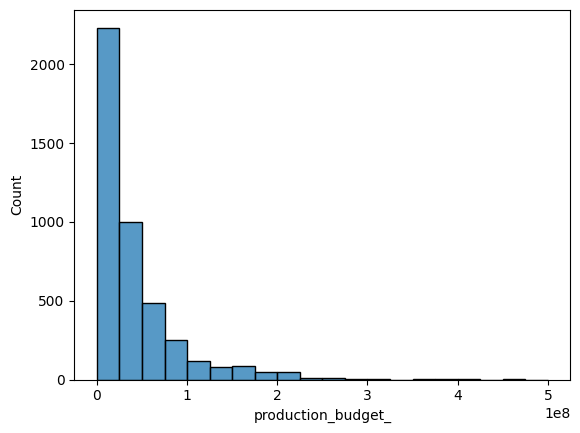

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(df["production_budget_"], binwidth = 25000000, binrange = (0,500000000))
len(df[df.production_budget_ < 25000000])

<Axes: xlabel='production_budget_'>

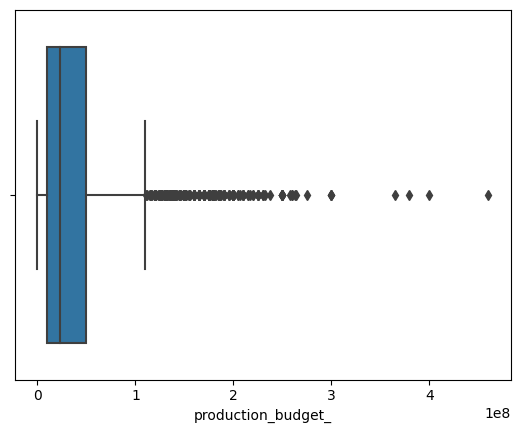

In [20]:
sns.boxplot(x = df.production_budget_)

3668

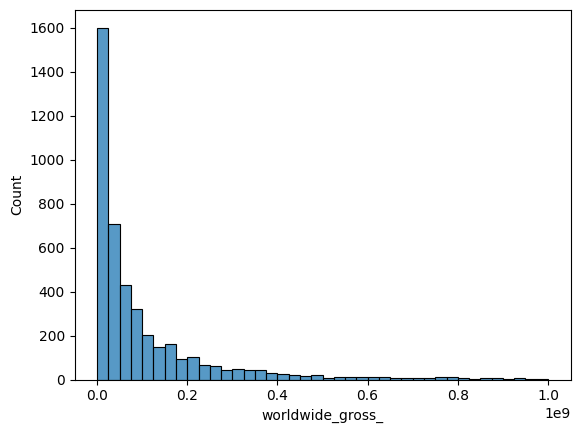

In [21]:
sns.histplot(df["worldwide_gross_"], binwidth = 25000000, binrange = (0,1000000000))
len(df[df.worldwide_gross_ < 200000000])

<Axes: xlabel='worldwide_gross_'>

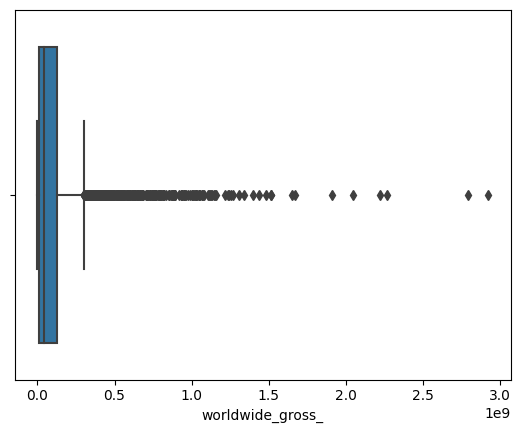

In [22]:
sns.boxplot(x = df.worldwide_gross_)

In [193]:
labels = df_encoded["worldwide_gross_"]
data = df_encoded.drop(labels = ["season","worldwide_gross_","domestic_gross_"], axis = 1)


In [194]:
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
scaled_data = scale(data, axis = 0)
train_data, test_data, train_labels, test_labels = train_test_split(scaled_data, labels, test_size = 0.2, random_state = 100)

In [186]:
#creating a standard error function
def standard_error(td,tl):
  #Mean Squared Error
  mean_squared_error = sum([(j - reg.predict(np.array(i).reshape(1, -1)))**2 for i,j in zip(td,tl)]) / len(td)
  return mean_squared_error[0]**0.5

In [195]:
#train the model
reg = LinearRegression().fit(train_data, train_labels)
#R^2 score
print(f"The value of R^2 is {reg.score(test_data,test_labels)}")
#this creates a list of tuples (real, predicted) in case you want to look
predictions_true = [(j,reg.predict(np.array(i).reshape(1, -1))) for i,j in zip(test_data,test_labels)]
#Standard Error
print(f"The standard error is {standard_error(test_data,test_labels)}")

The value of R^2 is 0.6969691577704562
The standard error is 115609778.004112


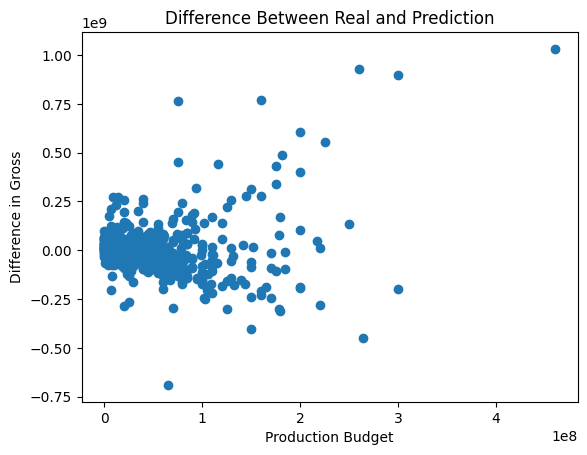

In [197]:
import matplotlib.pyplot as plt
t = [i-j[0] for i,j in predictions_true]
#t = [(i,j) for i,j in zip(data.iloc[test_labels.index]["production_budget_"],t)]
#sorted_list = sorted(t, key=lambda x: x[1])
#sorted_list
u = data.iloc[test_labels.index]["production_budget_"]
plt.scatter(u,t)
plt.title("Difference Between Real and Prediction")
plt.xlabel("Production Budget")
plt.ylabel("Difference in Gross")
plt.show()

In [198]:
from sklearn.feature_selection import SelectKBest, f_regression
r_average = [0] * 27
se_average = [0] * 27
for trial in range(100):
  rsquareds = []
  se = []
  for num in range(1,28):
    #feature selection algorithm is always ran on same random state
    scaled_data = scale(data, axis = 0)
    train_data, test_data, train_labels, test_labels = train_test_split(scaled_data, labels, test_size = 0.2,random_state=2308)
    k_best = SelectKBest(f_regression, k=num)
    X_new = k_best.fit_transform(train_data, train_labels)
    indices = k_best.get_support(indices=True)
    regression_cols = [data.columns[i] for i in indices]
    #choosing columns from the dataset and scaling
    new_data = data[regression_cols]
    new_scaled_data = scale(new_data, axis = 0)
    #no random state specified here so it will always be randomized
    train_data, test_data, train_labels, test_labels = train_test_split(new_scaled_data, labels, test_size = 0.2)
    #train the model
    reg = LinearRegression().fit(train_data, train_labels)
    rsquareds.append(reg.score(test_data,test_labels))
    se.append(standard_error(test_data,test_labels))
  r_average = [i + j for i,j in zip(rsquareds,r_average)]
  se_average = [i + j for i,j in zip(se,se_average)]


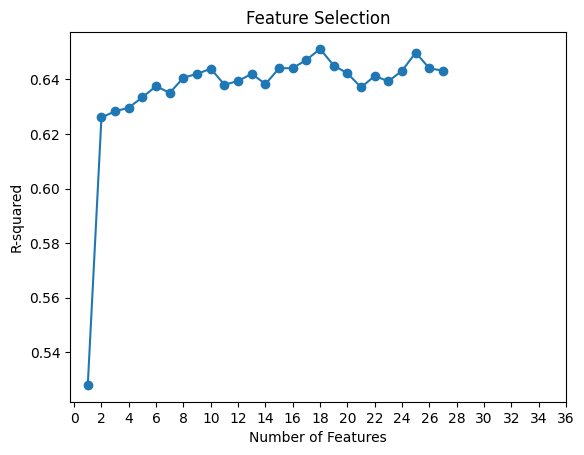

In [199]:
x = [i for i in range(1,28)]
y = [i/100 for i in r_average]
plt.plot(x,y, marker = "o")
plt.xlabel("Number of Features")
plt.ylabel("R-squared")
plt.xticks([i for i in range(0,38,2)])
plt.title("Feature Selection")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

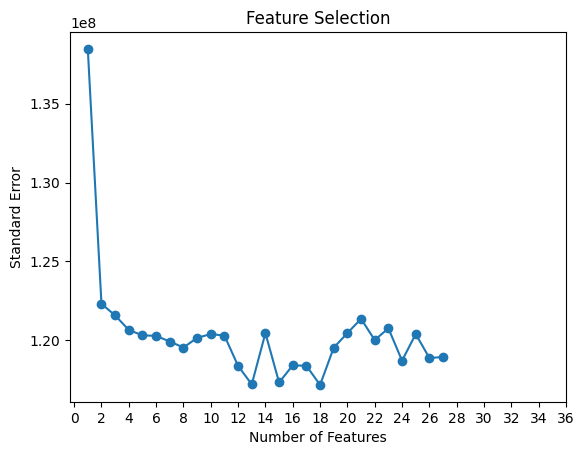

In [200]:
x = [i for i in range(1,28)]
y = [i/100 for i in se_average]
plt.plot(x,y, marker = "o")
plt.xlabel("Number of Features")
plt.ylabel("Standard Error")
plt.xticks([i for i in range(0,38,2)])
plt.title("Feature Selection")
plt.show

In [203]:
scaled_data = scale(data, axis = 0)
train_data, test_data, train_labels, test_labels = train_test_split(scaled_data, labels, test_size = 0.2,random_state=2308)
k_best = SelectKBest(f_regression, k=13)
X_new = k_best.fit_transform(train_data, train_labels)
indices = k_best.get_support(indices=True)
regression_cols = [data.columns[i] for i in indices]
new_data = data[regression_cols]
new_scaled_data = scale(new_data, axis = 0)
train_data, test_data, train_labels, test_labels = train_test_split(new_scaled_data, labels, test_size = 0.2)
#train the model
reg = LinearRegression().fit(train_data, train_labels)
print(f"The value of R^2 is {reg.score(test_data,test_labels)}")
#this creates a list of tuples (real, predicted) in case you want to look
predictions_true = [(j,reg.predict(np.array(i).reshape(1, -1))[0]) for i,j in zip(test_data,test_labels)]
#Mean Squared Error
mean_squared_error = sum([(j - reg.predict(np.array(i).reshape(1, -1)))**2 for i,j in zip(test_data,test_labels)]) / len(test_data)
#Standard Error
print(f"The standard error is {mean_squared_error[0]**0.5}")

The value of R^2 is 0.7052166300524005
The standard error is 113127306.5616332


In [204]:
regression_cols

['runtime_minutes',
 'director_birthyear',
 'movie_averagerating',
 'movie_numerofvotes',
 'approval_index',
 'production_budget_',
 'year',
 'Action',
 'Adventure',
 'Drama',
 'No Genre',
 'director_rating',
 'Fall']

In [205]:

#romance
barbie = np.array([114,1983,7.4,202000,7,145000000,2023,0,0,0,0,8,0])
#drama
oppenheimer = np.array([180,1970,8.6,311000,8,100000000,2023,0,0,1,0,8,0])


In [206]:
barbie = scale(barbie, axis = 0)
print(f"Barbie's predicted gross is {reg.predict(barbie.reshape(1, -1))[0]} and the true gross is 1.05 billion")
oppenheimer = scale(oppenheimer, axis = 0)
print(f"Oppenheimer's predicted gross is {reg.predict(oppenheimer.reshape(1, -1))[0]} and the true gross is 552.9 million")

Barbie's predicted gross is 508354930.08950627 and the true gross is 1.05 billion
Oppenheimer's predicted gross is 508738565.4199824 and the true gross is 552.9 million


Trying out some different models; completely unfinished

# Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNet

#choosing columns from the dataset and scaling
data = df_encoded.drop(labels = ["movie_title","production_date","genres","director_name","director_professions","director_birthyear",
             "director_deathyear","production_budget_","domestic_gross_","worldwide_gross_","genre1","genre2","genre3","season"], axis = 1)
scaled_data = scale(data, axis = 0)
train_data, test_data, train_labels, test_labels = train_test_split(scaled_data, labels, test_size = 0.2, random_state = 4)

regr = ElasticNet(random_state=0)
regr.fit(train_data, train_labels)

regr.score(test_data,test_labels)

In [ ]:
#ElasticNet has built in variable selection
print(regr.n_features_in_)

# Ridge

In [ ]:
from sklearn.linear_model import Ridge
import pandas as pd
from numpy import arange
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
clf = Ridge(alpha=1.0)
clf.fit(train_data, train_labels)

In [ ]:
clf.score(test_data, test_labels)

0.7107350427036203

In [ ]:
#Mean Squared Error
mean_squared_error = sum([(j - clf.predict(np.array(i).reshape(1, -1)))**2 for i,j in zip(test_data,test_labels)]) / len(test_data)
#Standard Error
print(f"The standard error is {mean_squared_error[0]**0.5}")

The standard error is 115970794.8439692


In [ ]:
#trying it with less features
data = df_encoded[regression_cols]
response = df_encoded["worldwide_gross_"]
scaled_data = scale(data, axis = 0)
train_data, test_data, train_labels, test_labels = train_test_split(scaled_data, labels, test_size = 0.2, random_state = 4)

clf = Ridge(alpha=1.0)
clf.fit(train_data, train_labels)

clf.score(test_data,test_labels)


0.6335535556194265

In [ ]:
#data = df_encoded[['runtime_minutes', 'director_birthyear', 'movie_averagerating', 'movie_numerofvotes', 'approval_index', 'production_budget_',
                  #'year', 'Action', 'Adventure', 'Animation', 'Crime', 'Drama', 'Fantasy', 'No Genre', 'Romance', 'Sci-Fi', "worldwide_gross_"]]

data[0:len(regression_cols)]
response[0:len(regression_cols)]
cross = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

model = RidgeCV(alphas=1, cv=cross, scoring='neg_mean_absolute_error')
#model.fit(data,response)